In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchdiffeq import odeint, odeint_adjoint

In [3]:
import torch.nn as nn
from torchdiffeq import odeint_adjoint

class ODEfunc(nn.Module):
    def __init__(self, dim):
        super(ODEfunc, self).__init__()
        self.dim = dim
        self.mid_dim = 100
        self.seq = nn.Sequential(
            nn.Linear(dim, self.mid_dim),
            nn.ReLU(),
            nn.Linear(self.mid_dim, self.mid_dim),
            nn.ReLU(),
            nn.Linear(self.mid_dim, dim),
            # nn.Tanh()
        )

    def forward(self, t, x):
        return self.seq(x)


class ODEBlock(nn.Module):
    def __init__(self, odefunc):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc
        self.integration_time = torch.tensor([0, 1]).float()

    def forward(self, x, t):
        # integration_time = self.integration_time.type_as(x)
        
        out = odeint_adjoint(self.odefunc, x, t.reshape(-1), rtol=1e-4, atol=1e-4)
        return out


class ODEnetSimple(nn.Module):
    def __init__(self, out_dim):
        super(ODEnetSimple, self).__init__()

        odefunc = ODEfunc(dim=out_dim)
        
        self.ode_block = ODEBlock(odefunc)  #Use ODE Block
        # self.norm2 = nn.BatchNorm1d(mid_dim)
        # self.fc2 = nn.Linear(mid_dim, out_dim)

        # count the number of parameters
        print("Number of parameters:", sum([p.numel() for p in self.parameters()]))

    def forward(self, x, t):
        # print(x.shape)
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        
        out = self.ode_block(x, torch.flatten(t))
        # print(out.shape)
        # print(out)
        # out = self.norm2(out)
        # out = self.fc2(out)

        return out

In [4]:
import numpy as np

class Ball:
    def __init__(self, x0, r, move_func):
        self.x0 = x0
        self.r = r
        self.x = torch.clone(x0)
        self.t = 0
        self.move_func = move_func

    def step(self, dt):
        self.t += dt
        x = self.x
        self.x += dt*self.move_func(self.t, x)
        
        return self.x

    def reset(self):
        self.x = torch.clone(self.x0)
        self.t = 0


def move_fun_circle(t, x, w=1, exp_decay=1.):
    return torch.exp(-torch.tensor(exp_decay*t))*torch.tensor([-w*np.sin(w*t), w*np.cos(w*t)], dtype=torch.float64)    


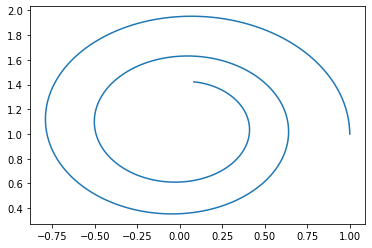

In [5]:
# create a ball and move it
N = 1000
dt = 1./N

def get_positions(ball, N, dt):
    positions = []
    for i in range(N):
        positions.append(ball.x.numpy().copy())
        ball.step(dt)  

    positions = np.stack(positions, axis=0)
    return positions

ball = Ball(torch.tensor([1.,1.]), 1.,lambda t,x: move_fun_circle(t, x, w=14, exp_decay=1.))
positions = get_positions(ball, N, dt)
# print(positions)
# display the positions in a plot 
plt.plot(positions[:,0], positions[:,1])
plt.show()

In [6]:
import torch.nn.functional as F
from tqdm.notebook import trange

class batchGetter:
    def __init__(self, batch_time, n_samples, total_length, dt, positions, frac_train, noise=-1):
        self.times = torch.linspace(0., total_length*dt, total_length, dtype=torch.float64).float()
        self.true_positions = torch.tensor(positions, dtype=torch.float64).float()
        self.noise = noise
        self.N_train = int(positions.shape[0]*frac_train)
        if noise > 0 and noise < 1:
            # adding gaussian noise to the true positions
            self.true_positions = self.true_positions + torch.normal(0, noise, size=self.true_positions.shape)
            self.true_positions = self.true_positions.float()

        self.train_times = self.times[:self.N_train]
        self.test_times = self.times[self.N_train:]
        self.train_positions = self.true_positions[:self.N_train]
        self.test_positions = self.true_positions[self.N_train:]
        self.n_samples = n_samples
        self.batch_time = batch_time
        self.dt = dt
        self.total_length = total_length

    def get_batch(self):
        s = torch.from_numpy(np.random.choice(np.arange(self.N_train - self.batch_time, dtype=np.int64), self.n_samples, replace=False))
        batch_y0 = self.train_positions[s]  # (M, D)
        batch_t = self.train_times[:self.batch_time]  # (T)
        batch_y = torch.stack([self.train_positions[s + i] for i in range(self.batch_time)], dim=0)  # (T, M, D)
        return batch_y0, batch_t, batch_y

# train our ODENet on the Ball motion

def train(model, optimizer, scheduler, epochs, getter, display=100):
    
    model.train()
    iterator = trange(1, epochs+1)
    # just for the plot part
    for i in iterator:
        # get a random time sample
        batch_init_positions, batch_times, batch_true_positions = getter.get_batch()
        # compute the output of the model
        out = model(batch_init_positions, batch_times.to(device))
        # compute the loss
        loss = 100*F.mse_loss(out[:].view(-1,2), batch_true_positions[:].view(-1,2).to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # update the progress bar
        iterator.set_description_str(f'Loss: {loss.item():.8f}')

        if i % display == 0:
           display_results(i, model, ball, getter, getter.total_length, dt)

        scheduler.step()
        
    return None


def display_results(i, model, ball, getter, total_steps, dt):

    print("The graphs at epoch {}".format(i))
    with torch.no_grad():
        times = torch.linspace(0., total_steps*dt, total_steps, dtype=torch.float64).float()
        predicted_output = model(getter.train_positions[0].unsqueeze(0).to(device), times.to(device))
        # display in orange the predicted position and in blue the true position of the training set
        
        # ball.reset()
        # positions = get_positions(ball, final_time, dt)
        
        plt.plot(predicted_output[:,-1,0].cpu().detach().numpy(), 
                predicted_output[:,-1,1].cpu().detach().numpy(), 'orange', label="Predicted")

        # if getter.noise > 0 and getter.noise < 1:
        #     plt.scatter(getter.train_positions[:,0].cpu().detach().numpy(), 
        #         getter.train_positions[:,1].cpu().detach().numpy(), s=1, c='b', label="True train")

        #     plt.scatter(positions[N_train:,0].cpu().detach().numpy(), 
        #         positions[N_train:,1].cpu().detach().numpy(), s=1, c='cyan', label="True test")
        
        # else:
        plt.plot(getter.train_positions[:,0].cpu().detach().numpy(), 
            getter.train_positions[:,1].cpu().detach().numpy(), 'b', label="True train")

        plt.plot(positions[getter.N_train:,0], 
                positions[getter.N_train:,1], 'cyan', label="True test")

        plt.legend()
        plt.show()

        # print the X axis over the time
        plt.plot(times, positions[:,0], 'r', label="True X")
        plt.plot(times, predicted_output[:,-1,0].cpu().detach().numpy(), 'orange', label="Predicted X")
        plt.plot(getter.train_times, getter.train_positions[:,0].cpu().detach().numpy(), 'b', label="True train X")
        plt.legend()
        plt.show()

        plt.plot(times, positions[:,1], 'r', label="True X")
        plt.plot(times, predicted_output[:,-1,1].cpu().detach().numpy(), 'orange', label="Predicted X")
        plt.plot(getter.train_times, getter.train_positions[:,1].cpu().detach().numpy(), 'b', label="True train X")
        plt.legend()
        plt.show()

# Spiral

## Without noise

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ODEnetSimple(2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# train the model

Number of parameters: 1842


  0%|          | 0/1000 [00:00<?, ?it/s]

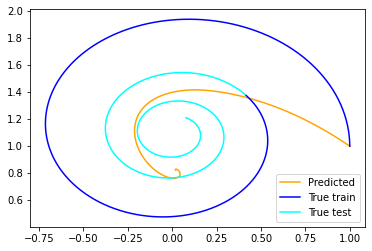

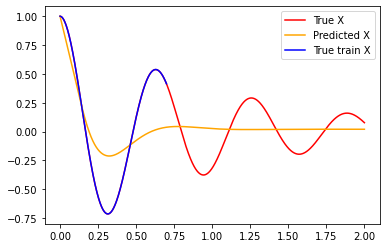

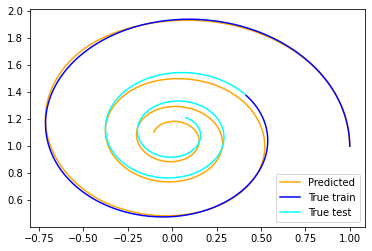

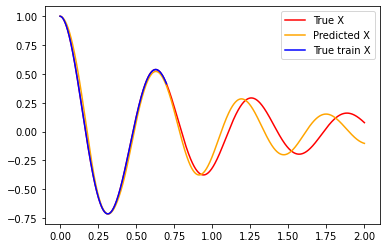

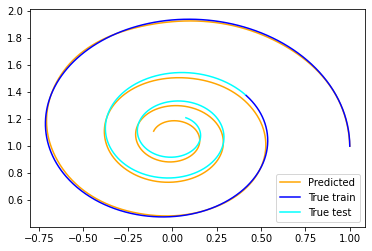

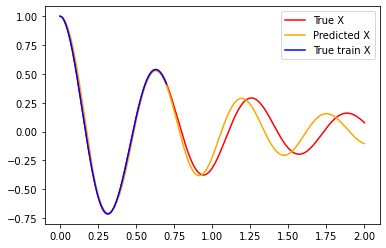

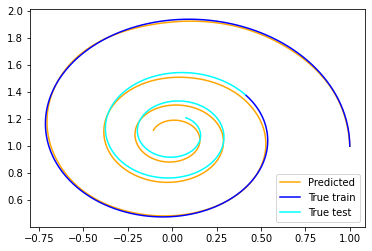

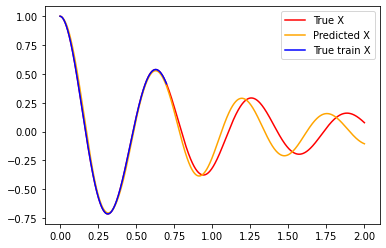

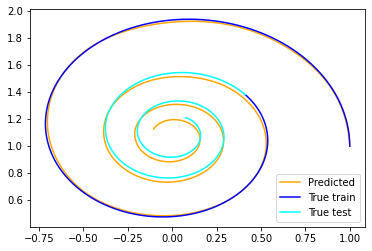

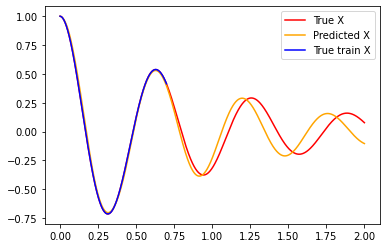

In [55]:
epochs = 1000
n_samples = 100
batch_time = 200

ball = Ball(torch.tensor([1.,1.]), 1.,lambda t,x: move_fun_circle(t, x, w=10, exp_decay=1.))
positions = get_positions(ball, N, dt)
getter = batchGetter(batch_time=batch_time, n_samples=n_samples, total_length=N, dt=dt, positions=positions, N_train=700, noise=-1)
train(model, optimizer, device, epochs, getter, display=200)

## With gaussian noise

In [56]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ODEnetSimple(2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Number of parameters: 1842


  0%|          | 0/1000 [00:00<?, ?it/s]

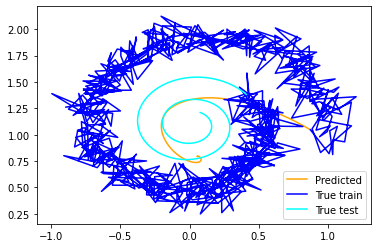

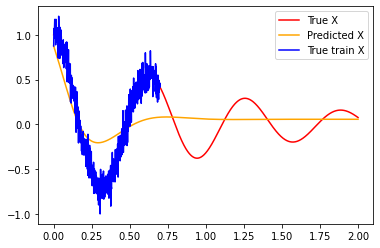

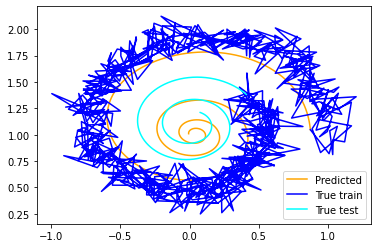

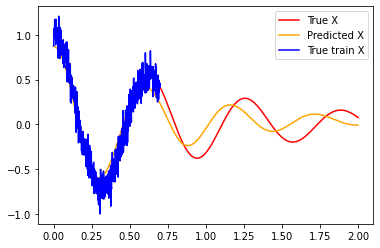

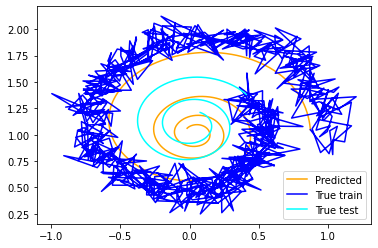

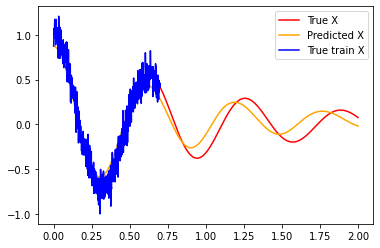

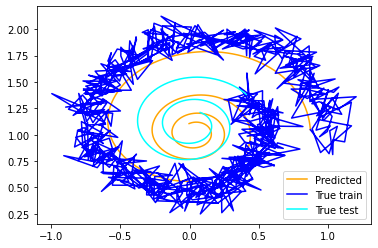

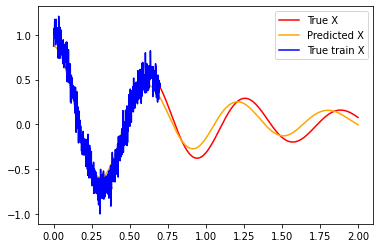

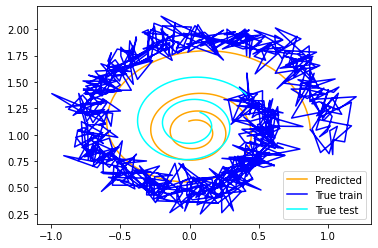

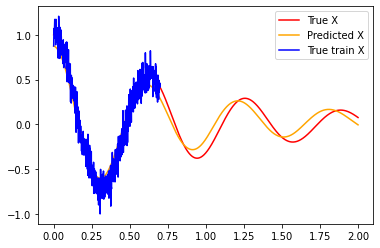

In [57]:
epochs = 1000
n_samples = 100
batch_time = 200

ball = Ball(torch.tensor([1.,1.]), 1.,lambda t,x: move_fun_circle(t, x, w=10, exp_decay=1.))
positions = get_positions(ball, N, dt)
getter = batchGetter(batch_time=batch_time, n_samples=n_samples, total_length=N, dt=dt, positions=positions, N_train=700, noise=0.1)
train(model, optimizer, device, epochs, getter, display=200)

# Circle

## Without noise

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ODEnetSimple(2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Number of parameters: 1842


  0%|          | 0/1000 [00:00<?, ?it/s]

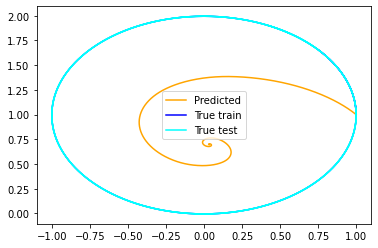

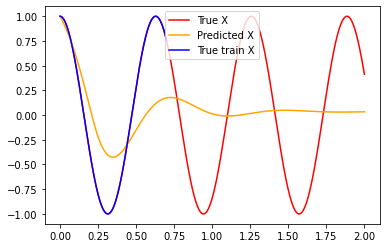

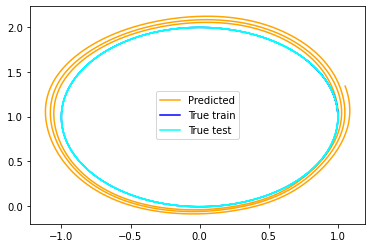

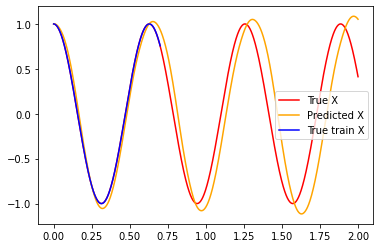

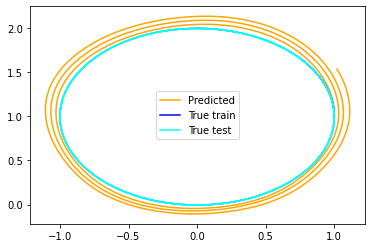

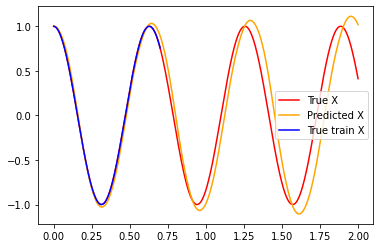

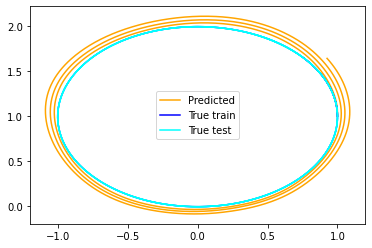

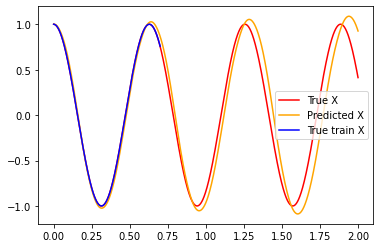

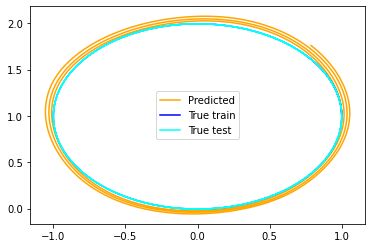

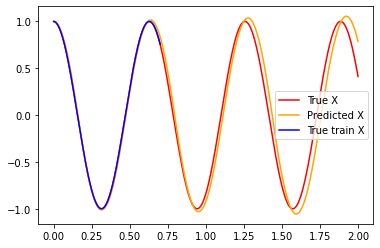

In [59]:
epochs = 1000
n_samples = 100
batch_time = 200

ball = Ball(torch.tensor([1.,1.]), 1.,lambda t,x: move_fun_circle(t, x, w=10, exp_decay=0.))
positions = get_positions(ball, N, dt)
getter = batchGetter(batch_time=batch_time, n_samples=n_samples, total_length=N, dt=dt, positions=positions, N_train=700, noise=-1)
train(model, optimizer, device, epochs, getter, display=200)

## With gaussian noise

In [60]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ODEnetSimple(2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Number of parameters: 1842


  0%|          | 0/1000 [00:00<?, ?it/s]

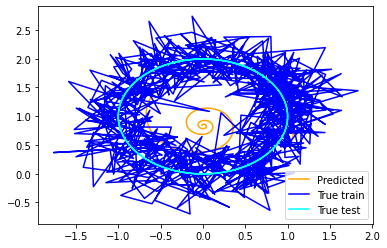

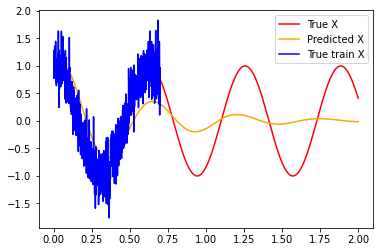

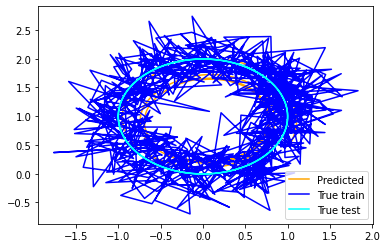

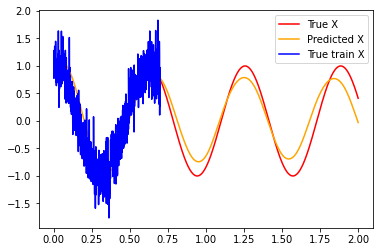

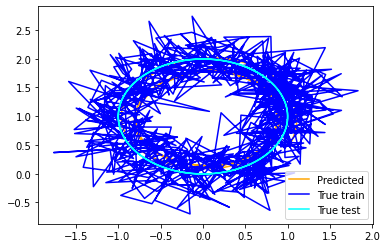

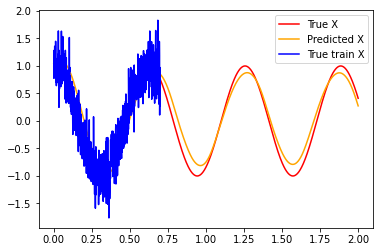

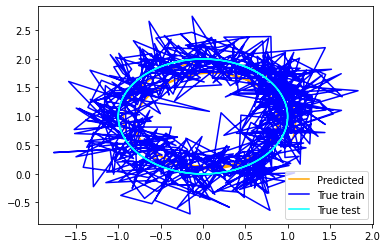

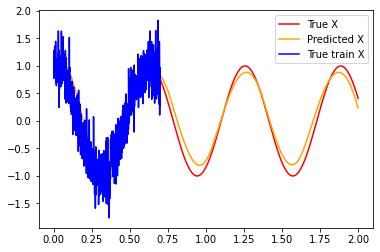

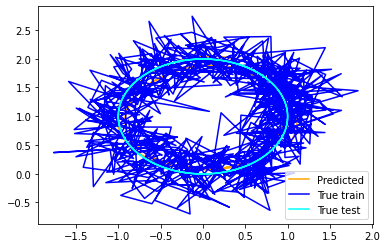

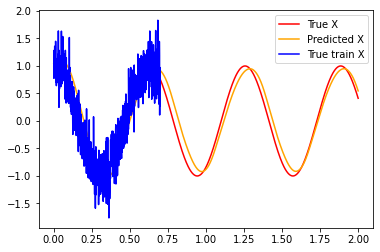

In [61]:
epochs = 1000
n_samples = 100
batch_time = 200

ball = Ball(torch.tensor([1.,1.]), 1.,lambda t,x: move_fun_circle(t, x, w=10, exp_decay=0.))
positions = get_positions(ball, N, dt)
getter = batchGetter(batch_time=batch_time, n_samples=n_samples, total_length=N, dt=dt, positions=positions, N_train=700, noise=0.3)
train(model, optimizer, device, epochs, getter, display=200)

# Latent Spiral

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ODEnetSimple(2)
# model.load_state_dict(torch.load('models/AE_ODE/spiral_encoded_0_4_final_data_mid_dim_100.pt'))

Number of parameters: 10602


In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

/var/folders/01/nfq6qhcj2j7dqfld6ps6vhbc0000gn/T/ipykernel_39093/1698997960.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.true_positions = torch.tensor(positions, dtype=torch.float64).float()


  0%|          | 0/1000 [00:00<?, ?it/s]

The graphs at epoch 100


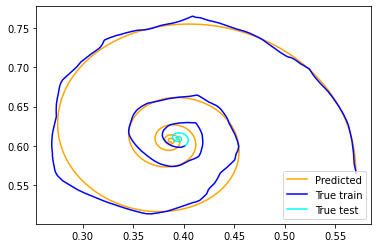

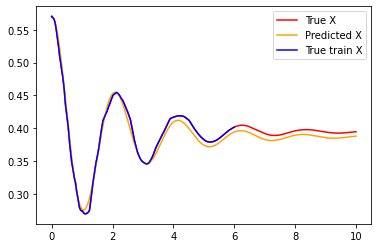

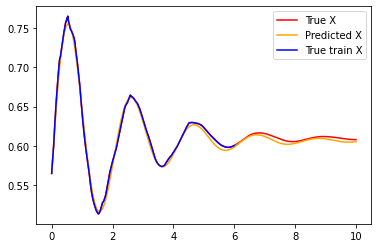

The graphs at epoch 200


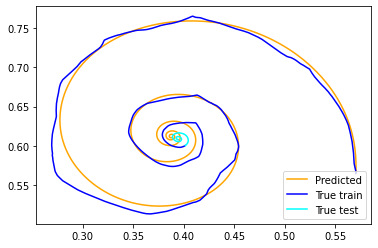

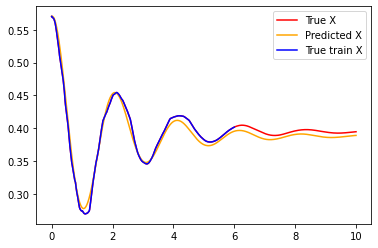

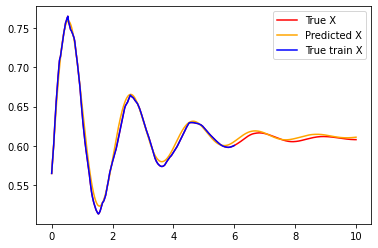

The graphs at epoch 300


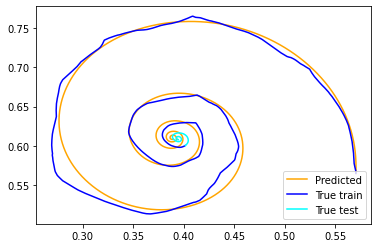

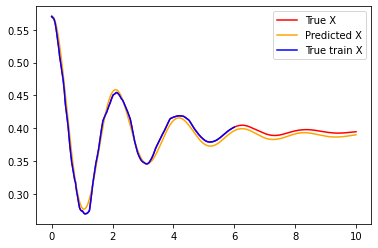

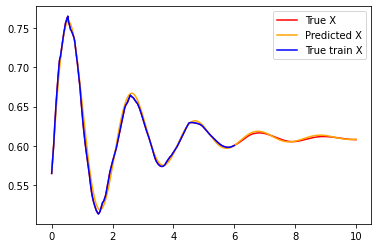

The graphs at epoch 400


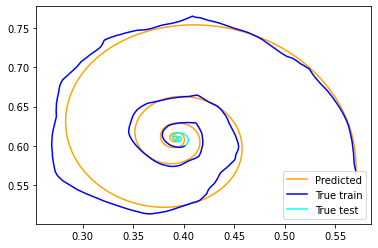

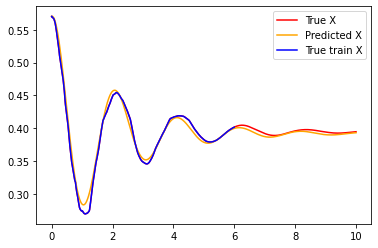

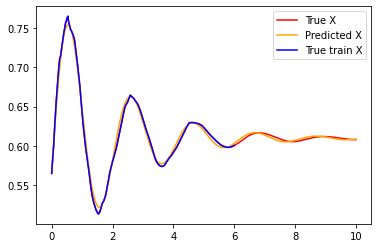

The graphs at epoch 500


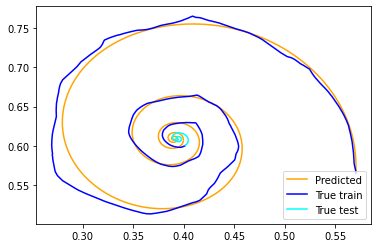

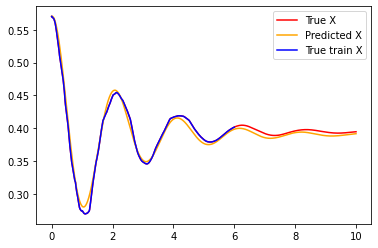

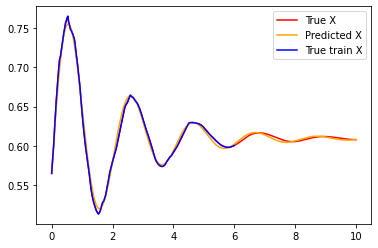

The graphs at epoch 600


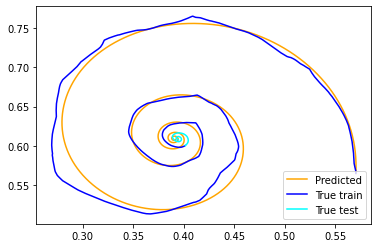

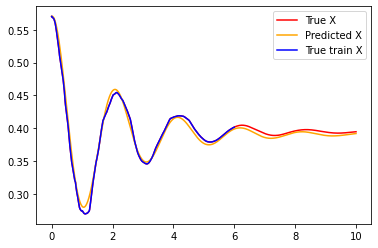

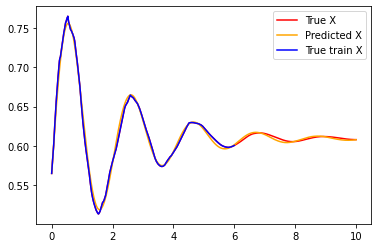

The graphs at epoch 700


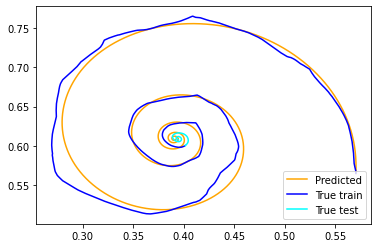

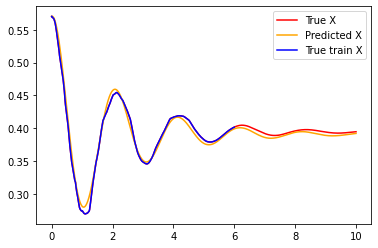

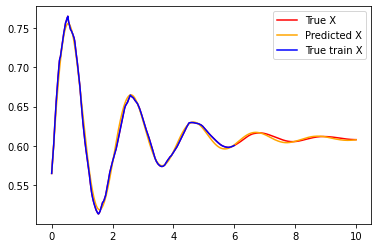

The graphs at epoch 800


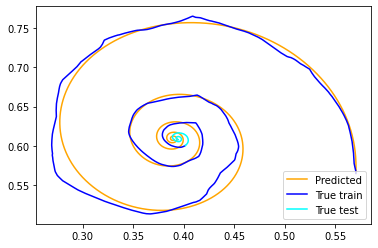

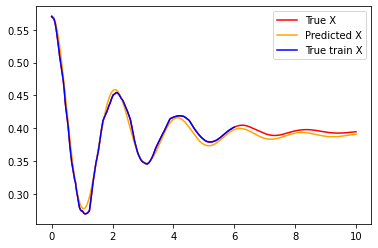

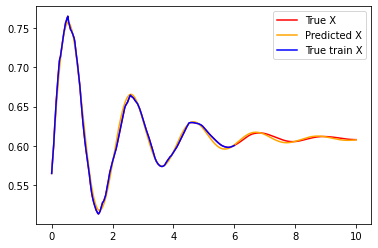

The graphs at epoch 900


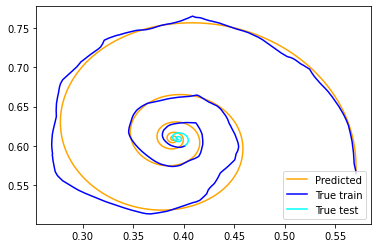

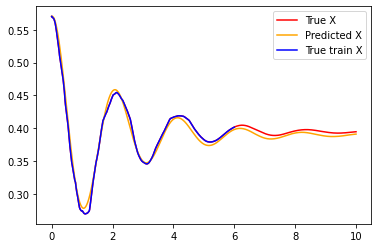

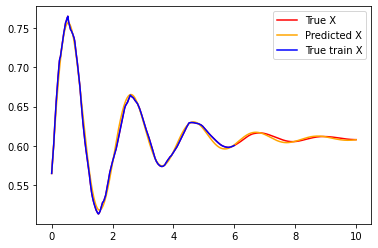

The graphs at epoch 1000


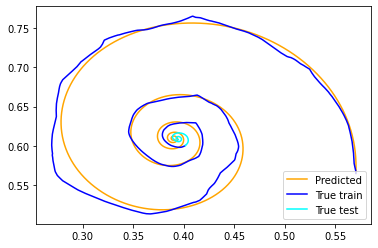

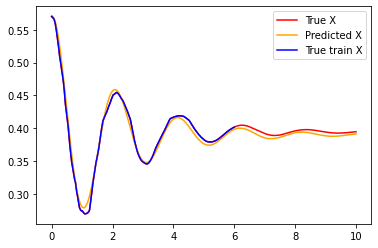

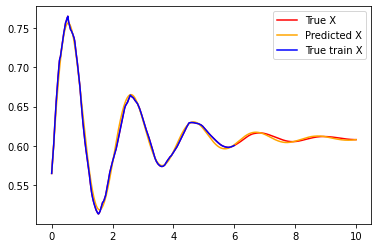

In [28]:
epochs = 1000
n_samples = 100
batch_time = 200
dt=0.001

positions = np.load("images/AE_ODE/encoded_reconstruction/centered_encoded_samples_fast_spiral_2.npy")
positions = torch.tensor(positions)
getter = batchGetter(batch_time=batch_time, n_samples=n_samples, total_length=positions.shape[0], dt=dt, positions=positions, frac_train=0.6)
train(model, optimizer, scheduler, epochs, getter, display=100)

In [19]:
torch.save(model.state_dict(), "models/AE_ODE/centered_spiral_encoded_0_6_final_data_mid_dim_100_v2.pt")